In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import tensorflow as tf

print(tf.__version__)

2.12.0


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import nltk
import re
import string
import warnings
import keras
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
from string import punctuation
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,Flatten
from keras.preprocessing import text, sequence
warnings.filterwarnings('ignore')
from tqdm import tqdm
import plotly.express as px

In [7]:
cd"/content/gdrive/MyDrive/AIML/LABS/NLP/News-Headlines-Dataset-For-Sarcasm-Detection-master"

/content/gdrive/MyDrive/AIML/LABS/NLP/News-Headlines-Dataset-For-Sarcasm-Detection-master


In [8]:
#1. Read and explore the data
import json
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [9]:
df = df.drop('article_link', axis=1)

In [10]:
#2. Retain relevant columns
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [11]:
#3. Get length of each sentence
df['length_of_sentence'] = df['headline'].apply(lambda x: len(x.split(" ")))
df.head()


,is_sarcastic,headline,length_of_sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


In [12]:
import nltk
from nltk.corpus import stopwords 

In [13]:
#4. Define parameters
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stopword = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopword.update(punctuation)

In [15]:
# web scraping to pull the data out of HTML and XML files
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [16]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [17]:
def remove_url(text):
    return re.sub(r'http\S+', '', text)

In [18]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopword:
            final_text.append(i.strip())
    return " ".join(final_text)

In [19]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

In [20]:
df['headline'] = df['headline'].apply(denoise_text)

In [21]:
df.head()

,is_sarcastic,headline,length_of_sentence
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails congress falling short ...,13
2,0,eat veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar getting work,8
4,1,mother comes pretty close using word 'streamin...,9


In [22]:
#5. Get indices for words
def clean_text(text):
    words_length=[]
    cleaned_data=[]
    for sent in tqdm(text):
        sent=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sent)
        words=[word for word in sent.split() if word not in stopwords.words('english')]
        words_length.append(len(words))
        cleaned_data.append(' '.join(words))
    return cleaned_data,words_length

In [23]:
df.headline,train_words_length=clean_text(df.headline)

100%|██████████| 28619/28619 [00:29<00:00, 969.46it/s] 


[]

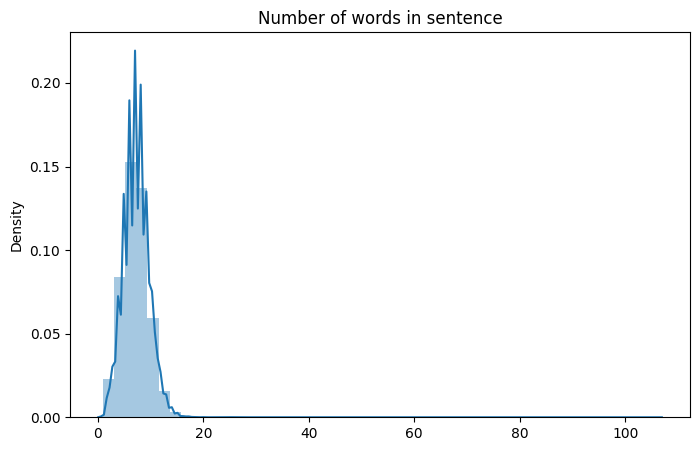

In [24]:
plt.figure(figsize=(8,5))
sns.distplot(train_words_length)
plt.title('Number of words in sentence')
plt.plot()

In [25]:
px.pie(df,names='is_sarcastic',labels=['not sarcastic','sarcastic'],title='Sarchastic')

In [26]:
X = df['headline']
y = df['is_sarcastic']

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3 , random_state = 0)


In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20033,)
(8586,)
(20033,)
(8586,)


In [29]:
#6. Create features and labels
max_features = 25000
max_len = 50

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)

# padding sequences with maximum length

X_train = pad_sequences(tokenized_train, maxlen=max_len)

print("Number of Samples:", len(X_train))       
print(X_train[0]) 

Number of Samples: 20033
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0  3358 12868 12869
   835  1074]


In [31]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
# padding sequences with maximum length

X_test = pad_sequences(tokenized_test, maxlen=max_len)

print("Number of Samples:", len(X_test))       
print(X_train[0]) 

Number of Samples: 8586
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0  3358 12868 12869
   835  1074]


In [32]:
#7. Get vocabulary size
tokenizer.word_index


{'new': 1,
 'trump': 2,
 'man': 3,
 'report': 4,
 'one': 5,
 'year': 6,
 'day': 7,
 'area': 8,
 'u': 9,
 'woman': 10,
 'time': 11,
 's': 12,
 'says': 13,
 'first': 14,
 'donald': 15,
 'old': 16,
 'get': 17,
 'like': 18,
 'life': 19,
 'obama': 20,
 "trump's": 21,
 "'": 22,
 'people': 23,
 'make': 24,
 'house': 25,
 'white': 26,
 'still': 27,
 'back': 28,
 'women': 29,
 'clinton': 30,
 '5': 31,
 'world': 32,
 'could': 33,
 'way': 34,
 'americans': 35,
 'family': 36,
 'study': 37,
 'would': 38,
 'gop': 39,
 'years': 40,
 'bill': 41,
 'really': 42,
 'last': 43,
 'finds': 44,
 'know': 45,
 '3': 46,
 'black': 47,
 'american': 48,
 'watch': 49,
 'home': 50,
 'going': 51,
 'nation': 52,
 '10': 53,
 "can't": 54,
 'school': 55,
 'video': 56,
 'best': 57,
 'state': 58,
 "'the": 59,
 'police': 60,
 'every': 61,
 'death': 62,
 'good': 63,
 'campaign': 64,
 'mom': 65,
 'show': 66,
 'hillary': 67,
 'president': 68,
 'big': 69,
 '000': 70,
 'right': 71,
 '2': 72,
 'things': 73,
 'getting': 74,
 'say':